In [1]:
import kagglehub

# Download the latest version of the PlantVillage dataset
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU memory growth enabled.
Num GPUs Available: 1
TensorFlow is using GPU: True
Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Found 20638 images belonging to 15 classes.
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Epoch 1/40
517/517 ━━━━━━━━━━━━━━━━━━━━ 283s 528ms/step - accuracy: 0.4652 - loss: 1.9541 - val_accuracy: 0.2266 - val_loss: 3.7076 - learning_rate: 0.0010
Epoch 2/40
517/517 ━━━━━━━━━━━━━━━━━━━━ 264s 505ms/step - accuracy: 0.6978 - loss: 1.1666 - val_accuracy: 0.3045 - val_loss: 5.8677 - learning_rate: 0.0010
Epoch 3/40
517/517 ━━━━━━━━━━━━━━━━━━━━ 321s 503ms/step - acc

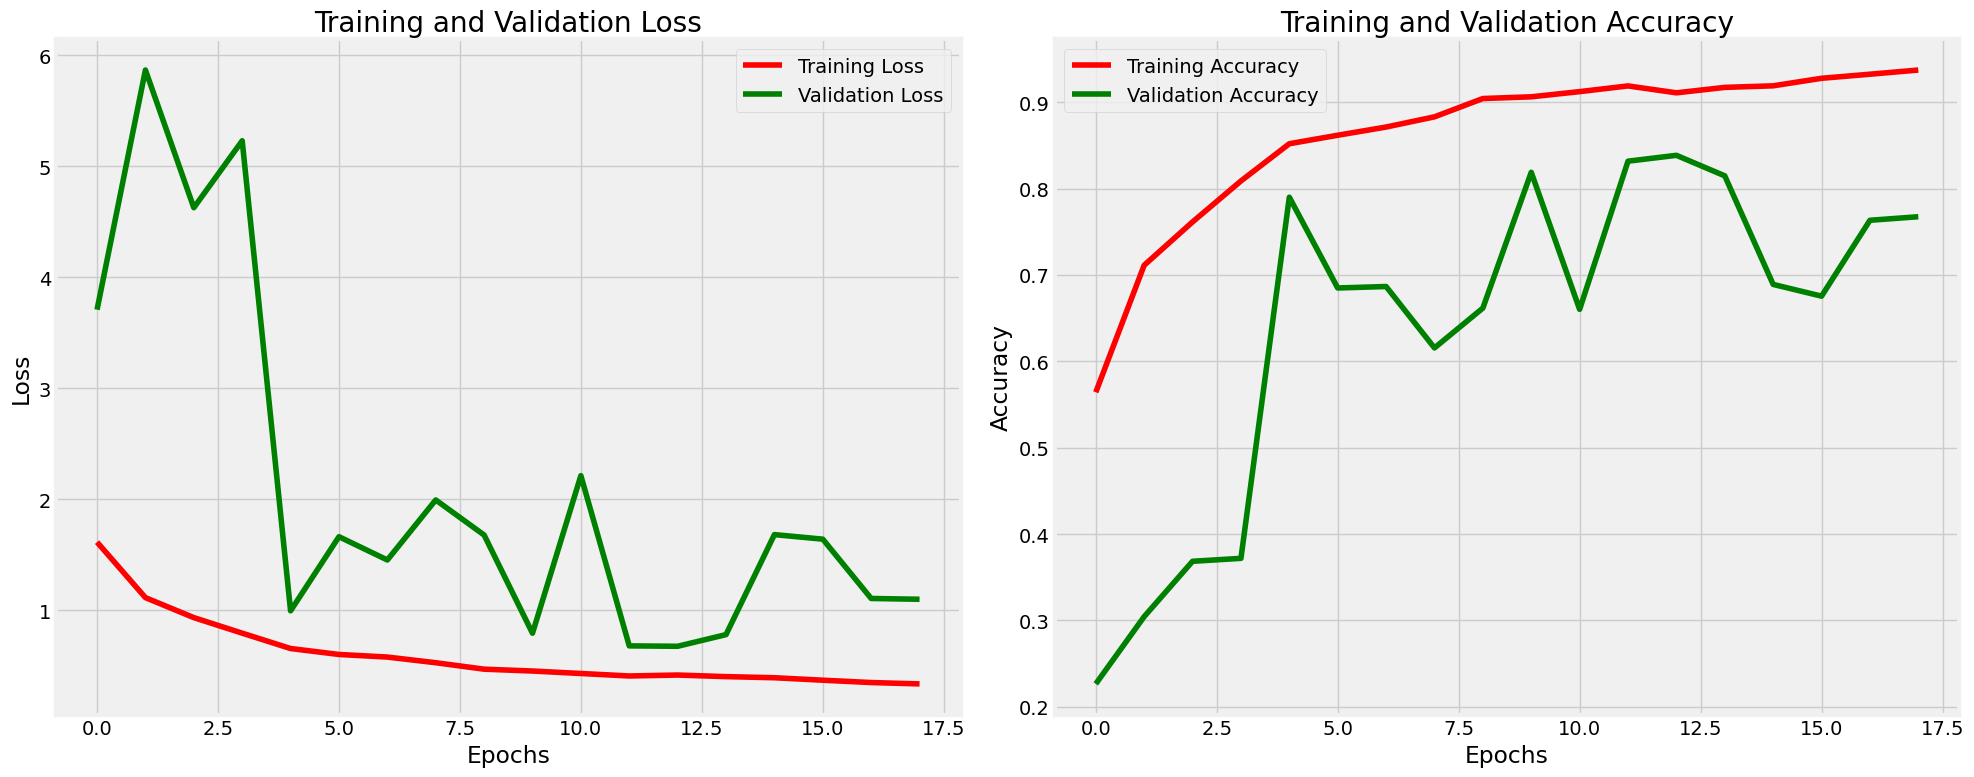

  2/645 ━━━━━━━━━━━━━━━━━━━━ 47s 73ms/step - accuracy: 0.8594 - loss: 0.7340  

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


645/645 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.8649 - loss: 0.5534
Test Loss:  0.6381512880325317
Test Accuracy:  0.8432503342628479
645/645 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step


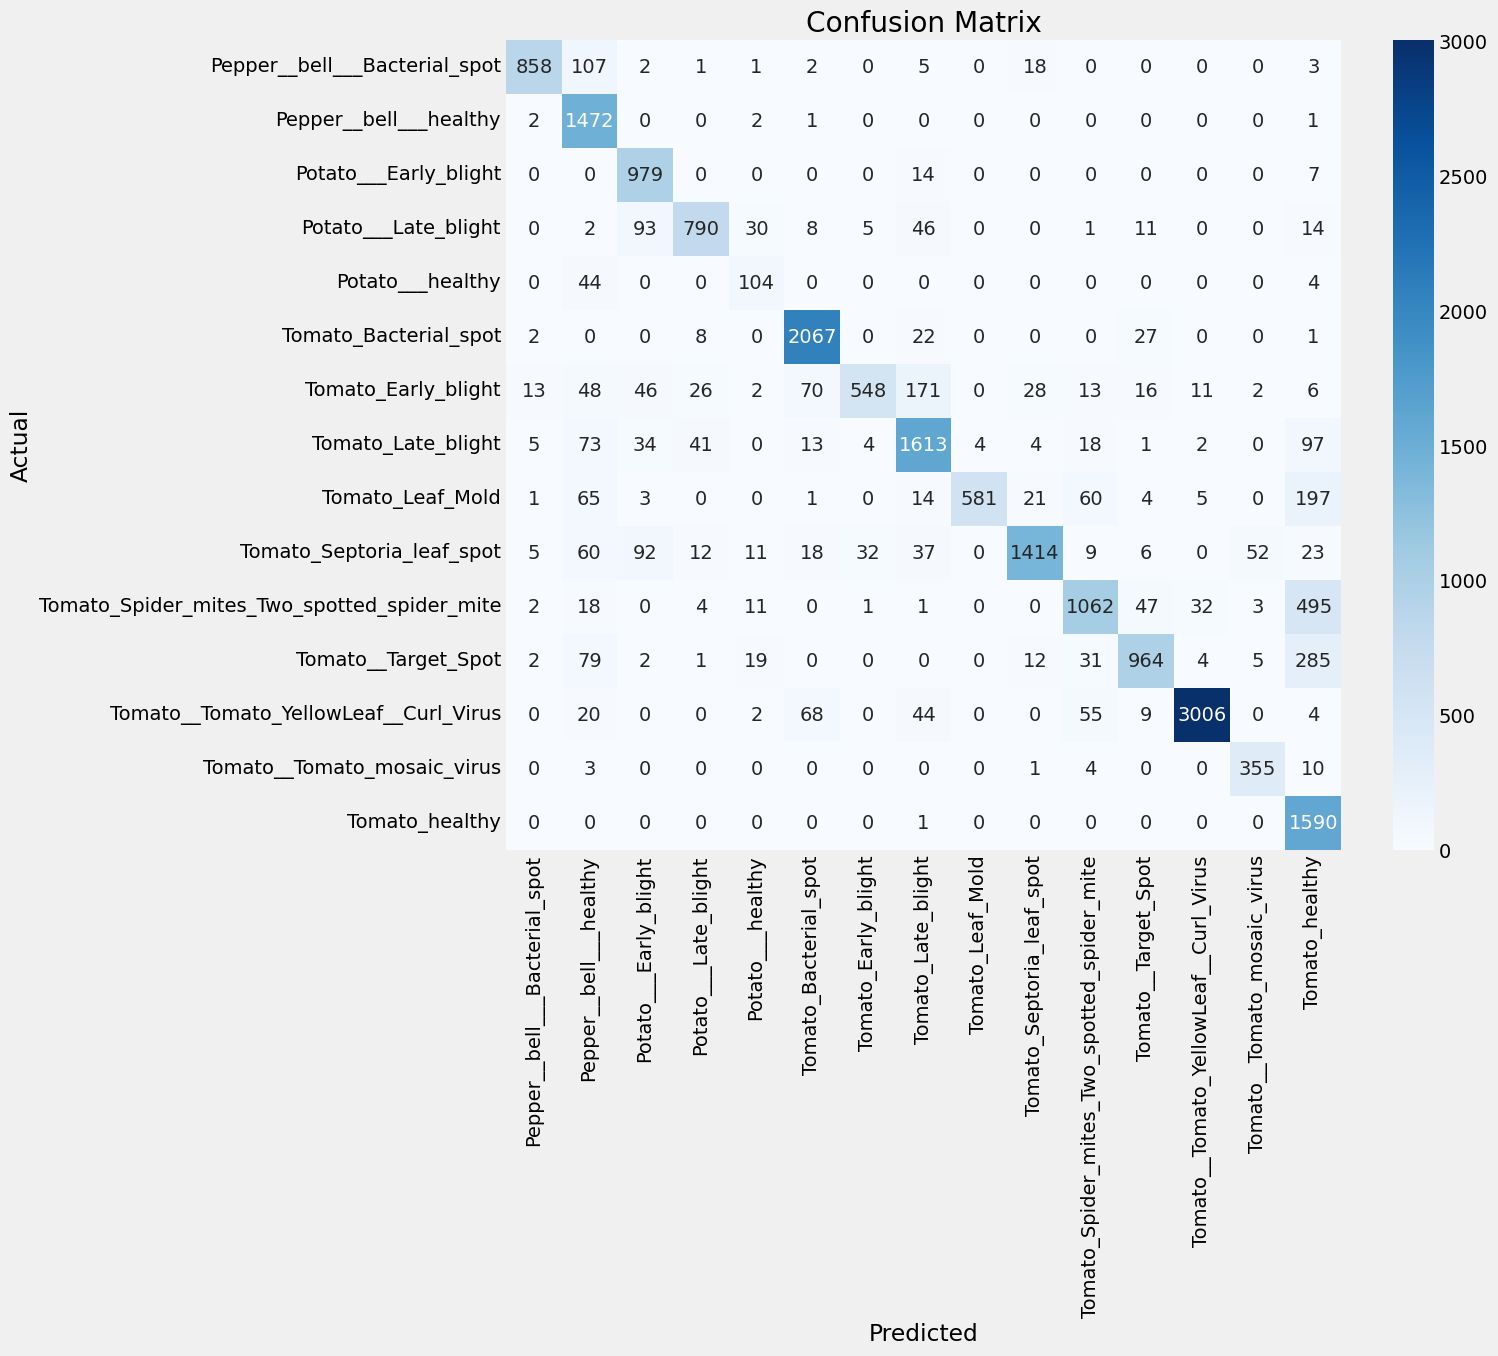

In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Enable GPU memory growth to avoid memory issues
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print(e)

# Verify GPU and CUDA availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_gpu_available(cuda_only=True))

# Dataset path
data_dir = '/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1/PlantVillage'

# Parameters
batch_size = 32
img_size = (256, 256)
epochs = 40
patience = 5  # Number of epochs to wait for early stopping
stop_patience = 3  # Number of patience epochs to stop if no improvement
factor = 0.5  # Factor to reduce learning rate by

# Data Preprocessing and Augmentation
def create_generators(data_dir, batch_size, img_size):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
    )

    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    train_gen = train_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=123
    )

    valid_gen = test_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=123
    )

    test_gen = test_datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, valid_gen, test_gen

# Create data generators
train_gen, valid_gen, test_gen = create_generators(data_dir, batch_size, img_size)

# Class names
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)
print(f"Classes: {class_names}")

# Build the CNN model
model = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=factor, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=valid_gen,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Plot training history
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    epochs_range = range(len(tr_acc))

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs_range, val_loss, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs_range, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

# Evaluate the model
test_score = model.evaluate(test_gen, verbose=1)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

# Confusion matrix
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
